In [33]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [34]:
#Load KPMG dataset
df_draft =pd.read_csv("KPMG Dataset.csv")

In [35]:
#Filtering orders_status is approved
is_Approved = df_draft['order_status'] == 'Approved'
df = df_draft[is_Approved]

In [36]:
df = df.drop_duplicates()
df = df.dropna(subset=['customer_id'])

In [37]:
# Create a function to get month from transaction_date
def get_month(x): return dt.datetime(x.year, x.month, 1)

In [38]:
#Convert transaction_date data type: from string to datetime
df["transaction_date"] =  pd.to_datetime(df["transaction_date"], format="%d/%m/%Y")
# Create transaction_date column based on month and store in TransactionMonth
df['order_month'] = df['transaction_date'].apply(get_month) 

In [39]:
# Grouping by customer_id and select order_month
Customer_group = df.groupby('customer_id')['order_month']
# Finding the first transaction.
df['CohortMonth'] = Customer_group.transform('min')

In [40]:
# Creating function to return year, month, day
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day
# Getting the integers for date parts from the `order_month` column
transcation_year, transaction_month, _ = get_date_int(df, 'order_month')
# Getting the integers for date parts from the `CohortDay` column
cohort_year, cohort_month, _ = get_date_int(df, 'CohortMonth')

In [41]:
#  Get the  difference in years
years_diff = transcation_year - cohort_year
# Calculate difference in months
months_diff = transaction_month - cohort_month
# calculate the difference in months between order_month vs CohortMonth
df['CohortIndex'] = years_diff * 12 + months_diff  + 1 

In [42]:
# Counting daily active user from each cohort
Customer_group = df.groupby(['CohortMonth', 'CohortIndex'])
# Counting number of unique customer_id in each group of CohortMonth and CohortIndex
cohort_data = Customer_group['customer_id'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()
 # Adding column names to the dataframe created above
cohort_counts = cohort_data.pivot(index='CohortMonth',
                                 columns ='CohortIndex',
                                 values = 'customer_id')

In [43]:
#Setup cohort_sizes + retention
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)

In [44]:
# Create retention index
retention.index = retention.index.strftime('%Y-%m')
retention.index

Index(['2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06',
       '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12'],
      dtype='object', name='CohortMonth')

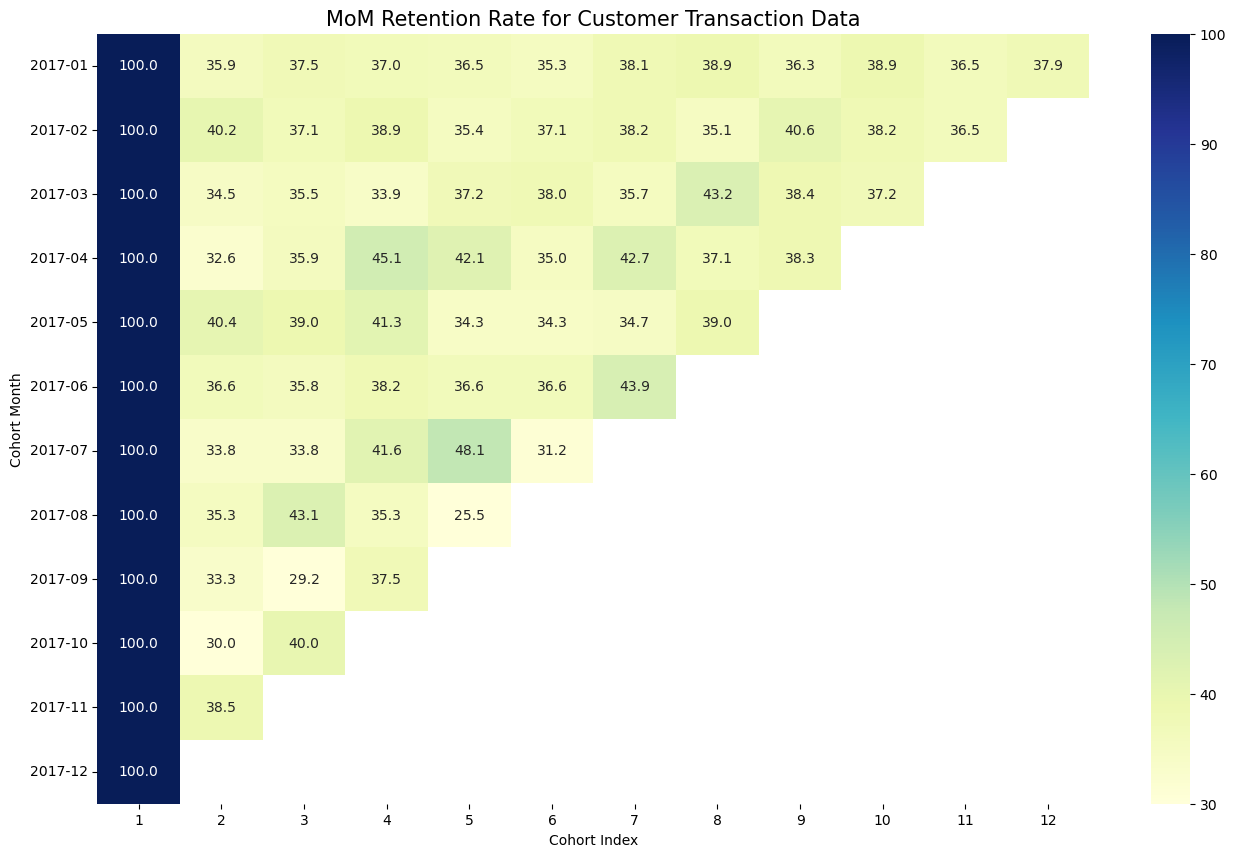

In [45]:
# Setup the figure size
plt.figure(figsize=(16, 10))

# Adding title for cohort chart
plt.title('MoM Retention Rate for Customer Transaction Data', fontsize = 15)

# Creating the cohort chart
sns.heatmap((retention*100).round(1), annot=True, fmt= '',cmap='YlGnBu', vmin = 30 , vmax = 100)
plt.ylabel('Cohort Month')
plt.xlabel('Cohort Index')
plt.yticks( rotation='360')
plt.show()